# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [9]:
# Imports here
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

## Load the data

Here I'll use `torchvision` to load the data. The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performances. I also made sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this, I did not do any scaling or rotation transformations, but I did resize and crop the images to the appropriate size.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I needed to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [10]:
#Defining the directories for the data
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [11]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir,transform=test_val_transforms)
test_dataset = datasets.ImageFolder(test_dir,transform=test_val_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### Label mapping
I also loaded in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [12]:
# Open the json file and load it.
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, I built and trained the classifier.  I used one of the pretrained models from `torchvision.models` to get the image features. And them I built and trained a new feed-forward classifier using those features. When training I made sure I was updating only the weights of the feed-forward network.

In [5]:
# Build and train your network
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
classifier = nn.Sequential(nn.Linear(25088,512),
                           nn.ReLU(),
                           nn.Linear(512,256),
                           nn.ReLU(),
                           nn.Linear(256,102),
                           nn.LogSoftmax(dim=1))
    
model.classifier = classifier

In [ ]:
#Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [16]:
# Use CUDA instead of cpu
device = 'cuda:0'
# change to device
model.to(device);

In [8]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.

# Define deep learning method
epochs = 1
steps = 0
running_loss = 0
print_every = 5 # Prints every 5 images out of batch of 50 images

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #where optimizer is working on classifier paramters only

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # loss.item () returns scalar value of Loss function

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval() #switching to evaluation mode so that dropout is turned off
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate validation loss and validation accuracy for Validation datset
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            #Print the details during the model training
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            
            running_loss = 0
            model.train(); #Set model back to training mode

Epoch 1/1.. Train loss: 4.590.. Validation loss: 4.422.. Validation accuracy: 0.079
Epoch 1/1.. Train loss: 4.166.. Validation loss: 3.969.. Validation accuracy: 0.157
Epoch 1/1.. Train loss: 3.969.. Validation loss: 3.468.. Validation accuracy: 0.275
Epoch 1/1.. Train loss: 3.547.. Validation loss: 3.030.. Validation accuracy: 0.363
Epoch 1/1.. Train loss: 3.052.. Validation loss: 2.726.. Validation accuracy: 0.391
Epoch 1/1.. Train loss: 2.857.. Validation loss: 2.258.. Validation accuracy: 0.468
Epoch 1/1.. Train loss: 2.444.. Validation loss: 1.989.. Validation accuracy: 0.506
Epoch 1/1.. Train loss: 2.219.. Validation loss: 1.869.. Validation accuracy: 0.510
Epoch 1/1.. Train loss: 2.115.. Validation loss: 1.646.. Validation accuracy: 0.553
Epoch 1/1.. Train loss: 2.137.. Validation loss: 1.582.. Validation accuracy: 0.579
Epoch 1/1.. Train loss: 1.918.. Validation loss: 1.354.. Validation accuracy: 0.633
Epoch 1/1.. Train loss: 1.677.. Validation loss: 1.268.. Validation accuracy

# Testing your network
It's good practice to test your trained network on test data. This will give  a good estimate for the model's performance on completely new images.

In [17]:
# Do validation on the test set
accuracy = 0

model.eval() #switching to evaluation mode so that dropout is turned off

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)

        # Calculate Validation loss and Validation accuracy for test dat set
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(testloader):.3f}")

model.train(); #Set model back to training mode

Test accuracy: 0.715


## Save the checkpoint

Now that the network is trained, I saved the model so I can load it later for making predictions. I saved other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. I can attach this to the model as an attribute which makes inference easier later on. I also saved the number of epochs as well as the optimizer state, `optimizer.state_dict`.

In [10]:
# Save the checkpoint  

#saving mapping between predicted class and class name
#second variable is a class name in numeric 
model.idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

#creating dictionary 
checkpoint = {
            'model':model,
             'state_dict':model.state_dict(),
             'optimizer_dict':optimizer.state_dict(),
            'idx_to_class':model.idx_to_class
            }


torch.save (checkpoint, 'checkpoint.pth')

## Loading the checkpoint

I wrote a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [13]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(path):
    checkpoint = torch.load(path)

    #load the model
    model = checkpoint['model']
    
    #load the state_dicts
    model.load_state_dict(checkpoint['state_dict'])
    
    #Load optimizer state dicts
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    
    model.idx_to_class = checkpoint['idx_to_class']
    
    return model

In [14]:
# Load the model
model = load_checkpoint('checkpoint.pth')

# Define the loss
criterion = nn.NLLLoss()

# Image Preprocessing

I used PIL to load the image. I wrote a function that preprocesses the image so it can be used as input for the model. This function processes the images in the same manner used for training.

First, I resized the images where the shortest side is 256 pixels, keeping the aspect ratio. Then I cropped out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I needed to convert the values. I did it with a Numpy array, which you can get from a PIL image.

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. I subtracted the means from each color channel, then divided by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I reordered dimensions using ndarray.transpose.

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    image = Image.open(image)
        
    # Process a PIL image for use in a PyTorch model
    
    # Get original dimensions
    w, h = image.size

    # Find longer side to crop 
    if w < h: 
        resize_size=(256, 1024)
    else: 
        resize_size=(1024, 256)
 
    image.thumbnail(resize_size)
    
    # crop
    crop_size = 224
    width, height = image.size   # Get dimensions
    
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    
    image = image.crop((left, top, right, bottom))
    
    np_image = np.array(image)
    
    # normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_array = np.array(image) / 255
    
    image = (image_array - mean) / std
    
    # reorder dimensions for color channel
    image = image.transpose((2,0,1))
    
    return torch.from_numpy(image)

The function below converts a PyTorch tensor and displays it in the notebook. If the  `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

I wrote a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I calculated the class probabilities then found the $K$ largest values.

To get the top $K$ largest values in a tensor, I used [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I need to convert from these indices to the actual class labels using `class_to_idx` which I added to the model or from an `ImageFolder` that I used to load the data. I inverted the dictionary so I can get a mapping from index to class as well.

In [15]:
# This method should take a path to an image and a model checkpoint, then return the probabilities and classes.
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    #loading image and processing it using above defined function
    image = process_image(image_path)
    
    #used to make size of torch as expected. as forward method is working with batches,
    #doing that we will have batch size equal to 1
    image = image.unsqueeze_(0) 
    
    #we cannot pass image to model.forward 'as is' as it is expecting tensor, not numpy array
    #converting to tensor
    image = image.cuda().float()
    
    model.eval() # Turn off gradients for validation, saves memory and computations
    
    with torch.no_grad():
        logps = model.forward(image)
        ps = torch.exp(logps) #converting into a probability
        top_p, top_class = ps.topk(5)

    model.train() #Set model back to training mode
    
    #Converting idexes to class numbers
    class_nums = []
    for indexes in top_class.cpu().numpy()[0]:
        class_nums.append(model.idx_to_class[indexes])
        
    #coverting class numbers to names
    class_names = []
    for nums in class_nums:
        class_names.append(cat_to_name[str(nums)])
    
    probs = top_p.tolist()[0]  #converting to list
    
    return probs,class_nums,class_names

## Sanity Checking

I Used `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look

I converted from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, I used the `imshow` function defined above.

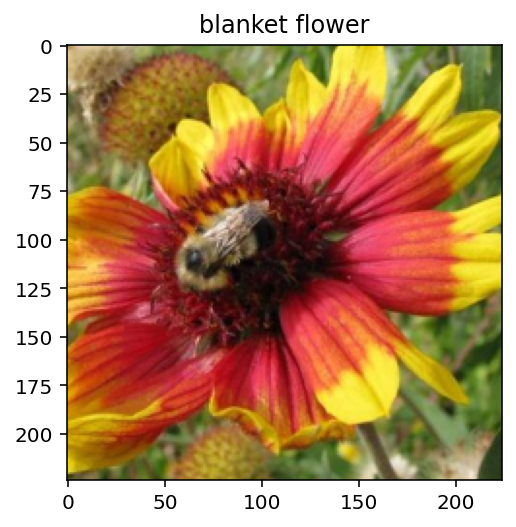

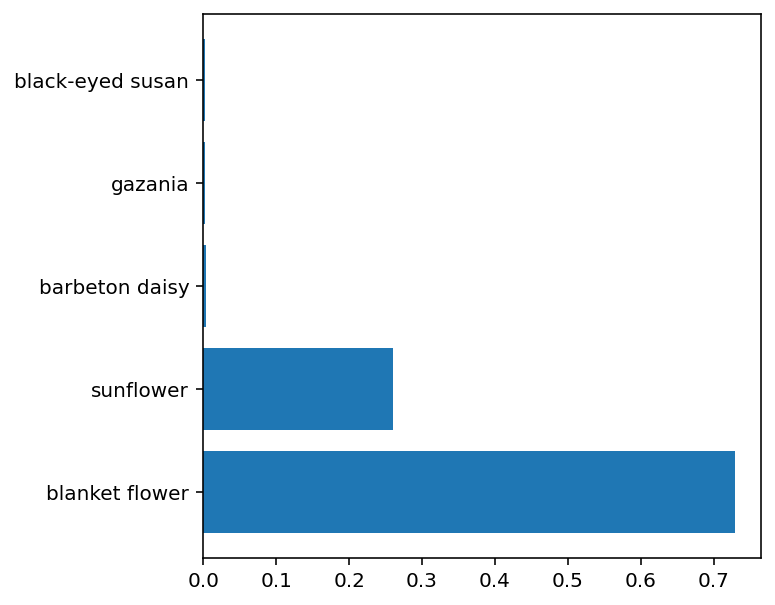

In [16]:
# Display an image along with the top 5 classes

# Define the image location
image_path = "flowers/test/100/image_07896.jpg"

# Predict the top K classses using the predict function
probs,class_indexes,class_names = predict(image_path, model)

#Show the image
ax = imshow(process_image(image_path))

#Set title as the actual flower name
flower_number = image_path.split('/')[2]
ax.set_title(cat_to_name[flower_number])

#Plot the graph
plt.figure(figsize=(5,5))
plt.barh(range(len(probs)),probs)
plt.yticks(range(len(probs)),class_names)
plt.show()